# Data Exploration

In [1]:
from DevelopedMethods.DF import *  # import np, pd, sklearn fn's --and df (https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data)

In [2]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


**notice <u>all numerical</u> features:**

**binary:** *smoking, sex, high_blood_pressure, diabetes, anaemia*

**non-binary:** *age, creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, serum_sodium, time*

## Feature Matrix (X) & Target/label Vector (y)

In [4]:
X = df.iloc[:, :-1]
y = df['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [5]:
stages = dict(DF=X, y=y, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test) # make running code / plotting stages easier

## Check For Imbalance

In [6]:
tmp = pd.concat([y.value_counts(), y.value_counts(normalize=True) * 100, y_train.value_counts(), y_train.value_counts(normalize=True) * 100], axis=1)
tmp.columns = ['DEATH_EVENT value count: y', f'out of ({len(y)} samples)    %', 'DEATH_EVENT value count: y_train', f'out of ({len(y_train)} samples)   %']
tmp

,DEATH_EVENT value count: y,out of (299 samples) %,DEATH_EVENT value count: y_train,out of (239 samples) %
DEATH_EVENT,,,,
0,203,67.892977,160,66.945607
1,96,32.107023,79,33.054393


## Mild imbalance. Explore SMOTE, weighted loss functions, or threshold tuning.
1. **SMOTE (Synthetic Minority Over-sampling Technique):** This technique generates synthetic samples for the minority class (DEATH_EVENT) to balance the dataset. It's effective but can introduce noise.
1. **Weighted Loss Functions:** higher weights to minority class **during training**. This approach helps the model focus more on correctly predicting the minority class without altering the dataset.
1. **Threshold Tuning:** Adjust the decision threshold of your model's predictions to improve sensitivity for the minority class. This is useful **after model training**.

In [7]:
smote = SMOTE(random_state=55)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"X_train ({len(X_train)}) => X_train_resampled ({len(X_train_resampled)})\n\n", y_train_resampled.value_counts())

X_train (239) => X_train_resampled (320)

 DEATH_EVENT
0    160
1    160
Name: count, dtype: int64


In [8]:
stages.update(dict(X_train_resampled=X_train_resampled, y_train_resampled=y_train_resampled))

**Detect SMOTE Noise:** PCA - SMOTE Original vs Synthetic Samples

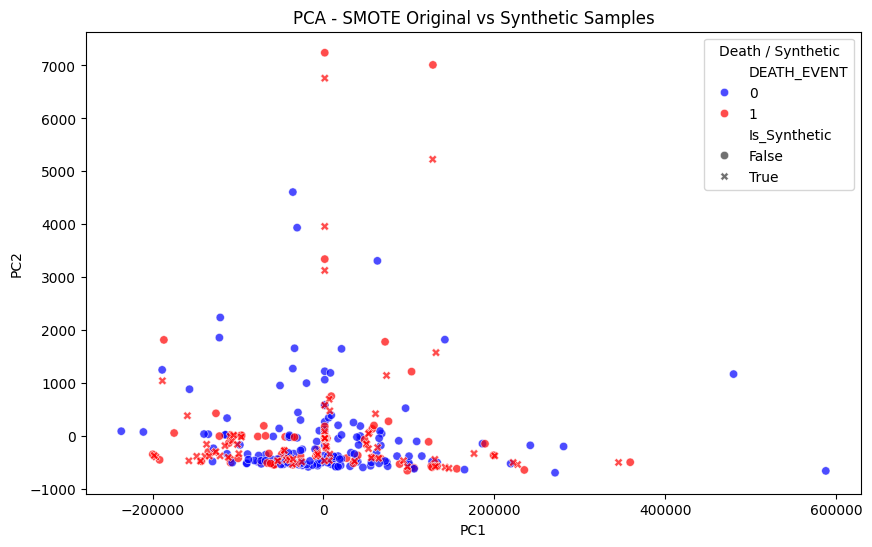

In [9]:
n_original = len(X_train)
synthetic_mask = np.array([False]*n_original + [True]*(len(X_train_resampled) - n_original)) # .map(() => is_synthetic)

pca = PCA(n_components=2, random_state=55) # apply PCA to reduce 2D (2 features) —for visualization
X_resampled_pca = pca.fit_transform(X_train_resampled)

# Build a plot DataFrame
plot_df = pd.DataFrame(X_resampled_pca, columns=["PC1", "PC2"])
plot_df["DEATH_EVENT"] = y_train_resampled
plot_df["Is_Synthetic"] = synthetic_mask

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,
    x="PC1", y="PC2",
    hue="DEATH_EVENT",
    style="Is_Synthetic",
    palette={0: "blue", 1: "red"},
    markers={False: "o", True: "X"},
    alpha=0.7
)
plt.title("PCA - SMOTE Original vs Synthetic Samples")
plt.legend(title="Death / Synthetic")
plt.show()


Blue circles = majority class original

Red circles = minority class original

Red X’s = synthetic samples added by SMOTE

... No outliers => no noise found. &nbsp; ie: &nbsp; X's (synthetic) are all near red circles (original's from minority class)

**Detect SMOTE Noise (2):** t-SNE (which can sometimes reveal tighter clusters ——better than PCA at preserving local structure)

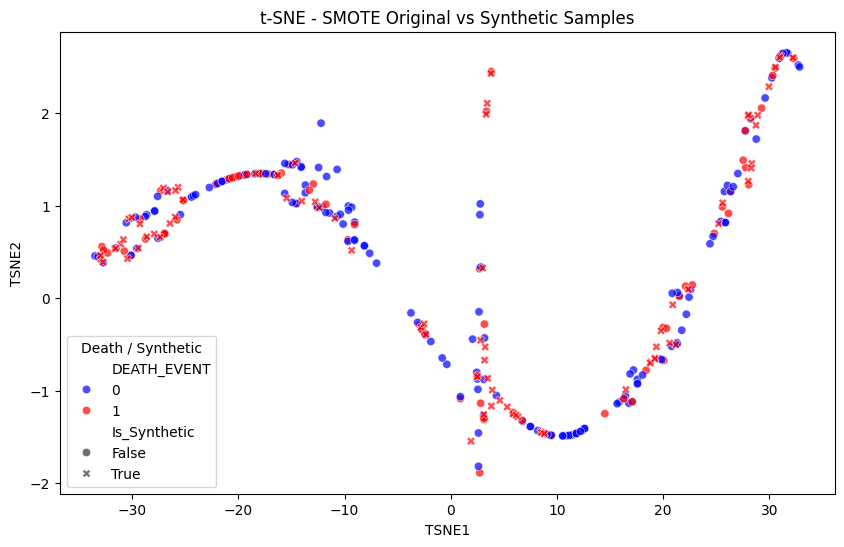

In [10]:
tsne = TSNE(n_components=2, random_state=55, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_train_resampled)

tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["DEATH_EVENT"] = y_train_resampled
tsne_df["Is_Synthetic"] = synthetic_mask

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=tsne_df,
    x="TSNE1", y="TSNE2",
    hue="DEATH_EVENT",
    style="Is_Synthetic",
    palette={0: "blue", 1: "red"},
    markers={False: "o", True: "X"},
    alpha=0.7
)
plt.title("t-SNE - SMOTE Original vs Synthetic Samples")
plt.legend(title="Death / Synthetic")
plt.show()


we see the same (but with a better view) &nbsp; ——synthetic samples all very close to original samples

### Decision Tree

In [11]:
# decisiontree
decisiontree = DecisionTreeClassifier(random_state=55)
decisiontree.fit(X_train, y_train)
decisiontree_predictions = decisiontree.predict(X_test)
print("decisiontree:\t\t\t", f"{metrics.accuracy_score(y_test, decisiontree_predictions) * 100:.3f}", '%')

# decisiontree_resampled
decisiontree_resampled = DecisionTreeClassifier(random_state=55)
decisiontree_resampled.fit(X_train_resampled, y_train_resampled)
decisiontree_resampled_predictions = decisiontree_resampled.predict(X_test)
print("decisiontree_resampled:\t", f"{metrics.accuracy_score(y_test, decisiontree_resampled_predictions) * 100: .3f}", '%')

decisiontree:			 76.667 %
decisiontree_resampled:	  80.000 %


#### Decision Tree — Feature Importance Analysis

In [12]:
tmp1 = pd.DataFrame({'feature': X.columns, 'importance': decisiontree.feature_importances_ * 100})
tmp1 = tmp1.sort_values(by='importance', ascending=False).reset_index(drop=True)
tmp2 = pd.DataFrame({'feature': X.columns, 'importance': decisiontree_resampled.feature_importances_ * 100})
tmp2 = tmp2.sort_values(by='importance', ascending=False).reset_index(drop=True)
tmp = pd.DataFrame({
    'best_ft': tmp1['feature'],
    'importance %': tmp1['importance'],
    '': pd.Series([""] * len(X.columns)), '&nbsp;': pd.Series([""] * len(X.columns)), # separator/padding cols
    'best_ft_resampled': tmp2['feature'],
    'importance % resampled': tmp2['importance'],
})
tmp.index += 1 # indexing starts @ 1
tmp

,best_ft,importance %,,&nbsp;,best_ft_resampled,importance % resampled
1,time,56.637594,,,time,43.278940
2,serum_creatinine,11.241331,,,serum_creatinine,15.808560
3,ejection_fraction,9.881947,,,ejection_fraction,11.737363
4,serum_sodium,6.537883,,,sex,6.309840
5,creatinine_phosphokinase,4.446909,,,age,6.292637
6,platelets,3.843057,,,serum_sodium,5.708066
7,age,3.449554,,,creatinine_phosphokinase,5.329298
8,diabetes,2.701175,,,platelets,3.249582
9,smoking,1.260549,,,high_blood_pressure,1.333333
10,anaemia,0.000000,,,anaemia,0.952381


most notable importance fluctuations: &nbsp; ejection_fraction ± 4.5%, &nbsp; age ± 3%

### Random Forest

In [13]:
# invariant to feature scaling (ie: skip randomforest_scaled/randomforest_resampled_scaled like in Decision Tree (also invariant))
randomforest = RandomForestClassifier(n_estimators=19, bootstrap=True, random_state=55)
randomforest.fit(X_train,  y_train)
randomforest_prediction = randomforest.predict(X_test)
print("randomforest:\t\t\t", f"{metrics.accuracy_score(y_test, randomforest_prediction) * 100:.3f}", "%")

# randomforest_resampled
randomforest_resampled = RandomForestClassifier(n_estimators=19, bootstrap=True, random_state=55)
randomforest_resampled.fit(X_train_resampled, y_train_resampled)
randomforest_resampled_prediction = randomforest_resampled.predict(X_test)
print("randomforest_resampled: ", f"{metrics.accuracy_score(y_test, randomforest_resampled_prediction) * 100:.3f}", "%")

randomforest:			 83.333 %
randomforest_resampled:  83.333 %


#### Random Forest — Feature Importance Analysis

In [14]:
tmp1 = pd.DataFrame({'feature': X.columns, 'importance': randomforest.feature_importances_ * 100})
tmp1 = tmp1.sort_values(by='importance', ascending=False).reset_index(drop=True)
tmp2 = pd.DataFrame({'feature': X.columns, 'importance': randomforest_resampled.feature_importances_ * 100})
tmp2 = tmp2.sort_values(by='importance', ascending=False).reset_index(drop=True)
tmp = pd.DataFrame({
    'best_ft': tmp1['feature'],
    'importance %': tmp1['importance'],
    '': pd.Series([""] * len(X.columns)), '&nbsp;': pd.Series([""] * len(X.columns)), # separator/padding cols
    'best_ft_resampled': tmp2['feature'],
    'importance % resampled': tmp2['importance'],
})
tmp.index += 1 # indexing starts @ 1
tmp

,best_ft,importance %,,&nbsp;,best_ft_resampled,importance % resampled
1,time,32.441364,,,time,29.730248
2,serum_creatinine,17.197926,,,serum_creatinine,20.287545
3,ejection_fraction,12.296742,,,ejection_fraction,11.815815
4,creatinine_phosphokinase,8.875402,,,serum_sodium,7.942870
5,platelets,7.961690,,,platelets,7.253283
6,age,6.739642,,,creatinine_phosphokinase,7.199333
7,serum_sodium,6.493393,,,age,6.876929
8,sex,2.299111,,,sex,3.188489
9,diabetes,1.535678,,,smoking,1.848797
10,smoking,1.520392,,,anaemia,1.437899


no huge fluctuations (little noise), but confirms most of decision tree: (ie: 1: time, 2: serum_creatinine, 3: ¿ejection_fraction?/creatinine_phosphokinase, platelets/age, serum_sodium, ...)

## Choosing a Scaler Function:

Inspect Gaussian Distribution (of values) across stages: (ie: X, X_train, X_train_resampled)

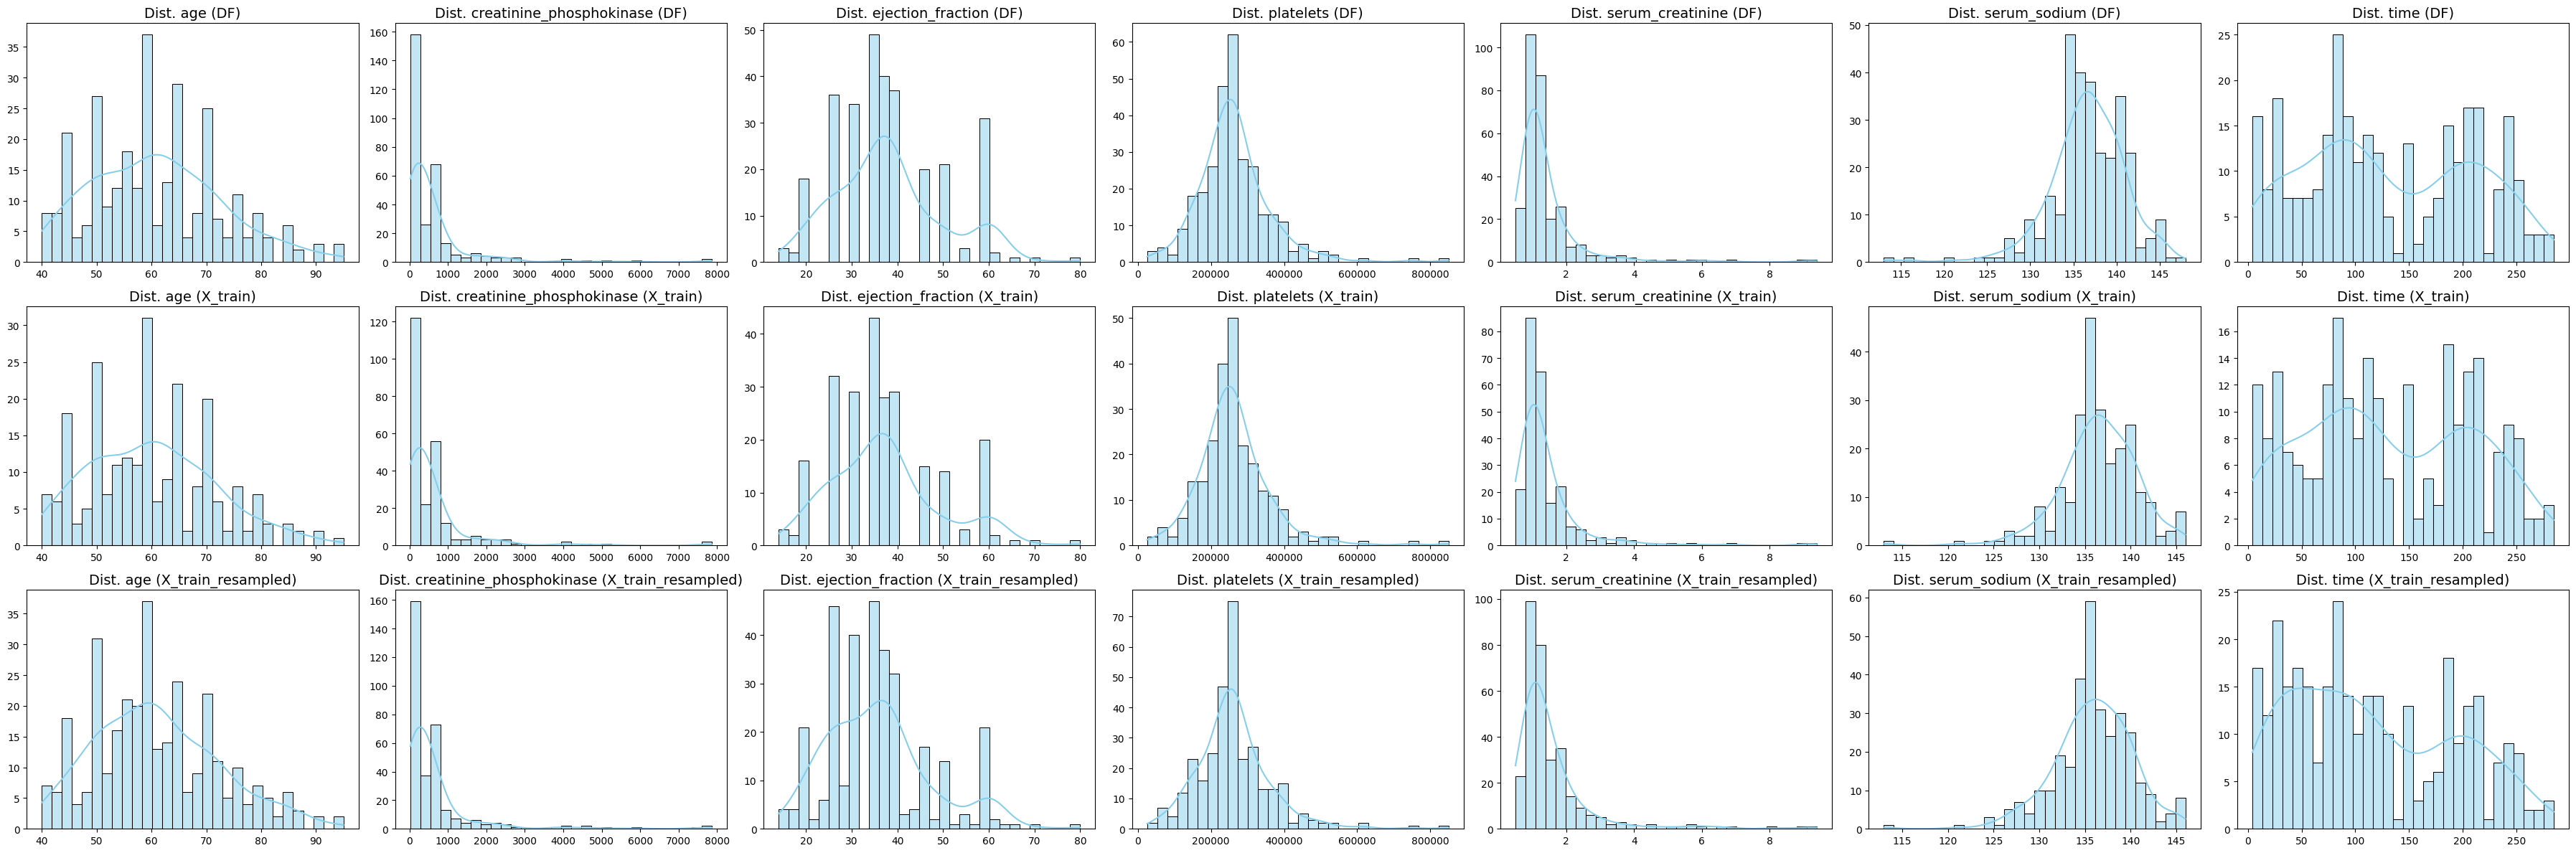

In [17]:
non_binary_features = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "time"]
_stages = dict()
for i in stages:
    if i.startswith("y") or i.find("_test") != -1: continue
    _stages[i] = stages[i]
rows = len(_stages) # 3
cols = len(non_binary_features)
plt.figure(figsize=(36, 12))
for i, df_key in enumerate(_stages.keys()):
    for j, feature in enumerate(non_binary_features):
        plot_no = i * cols + j + 1
        plt.subplot(rows, cols, plot_no) # focus plot_no in rowsXcols super-plot
        sns.histplot(_stages[df_key][feature], kde=True, bins=30, color='skyblue') # draw plot histogram w/ KDE "Kernel Density Estimate" (curve)
        plt.title(f"Dist. {feature} ({df_key})", fontsize=14)
        plt.xlabel(None)
        plt.ylabel(None)
plt.tight_layout()
plt.show()

These are the counts of the popularity of each feature-value in the datset. (ie: age: 60 is the most common in the dataset (see: the tallest bar/pile))

If Gaussian, KDE curve resembles a bell shape centered around the mean... Kernel Density Estimate/KDE curve is a smoothed approximation of feature-value distribution –like a continuous version of histogram)

**Observations**: &nbsp; Gaussian w/ few peaks; &nbsp; using SMOTE/resampled leads to following Gaussian curve more closely

=> use StandardScaler (Z-score normalization)


## Normalize/Scale

In [18]:
scaler = StandardScaler() # mean=0, standard deviation=1
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)
X_train_resampled_scaled = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns=X.columns, index=X_train_resampled.index)

minmax_scaler = MinMaxScaler() # values range [0,...,1]      **——note:** ANN often benefits from MinMaxScaler &nbsp; &nbsp;(likewise for SVM w/ StandardScaler)
X_train_minmax = pd.DataFrame(minmax_scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test_minmax = pd.DataFrame(minmax_scaler.transform(X_test), columns=X.columns, index=X_test.index)
X_train_resampled_minmax = pd.DataFrame(minmax_scaler.fit_transform(X_train_resampled), columns=X.columns, index=X_train_resampled.index)

In [19]:
stages.update(dict(X_train_scaled=X_train_scaled, X_test_scaled=X_test_scaled, X_train_resampled_scaled=X_train_resampled_scaled, X_train_minmax=X_train_minmax, X_test_minmax=X_test_minmax, X_train_resampled_minmax=X_train_resampled_minmax))

# Begin Classification Problem [0, 1] — Heart Failure Detection
Try traditional algorithms on: X_train, X_train_scaled, X_train_resampled, X_train_resampled_scaled

Logistic Regression

In [20]:
# scaling improves gradient descent/convergence speed (and won't need 'max_iter' increase)
# logisticregression
logisticregression = linear_model.LogisticRegression(random_state=55, max_iter=2000)
logisticregression.fit(X_train, y_train)
logisticregression_predictions = logisticregression.predict(X_test)
print(f"logisticregression:\t\t\t\t\t {metrics.accuracy_score(y_test, logisticregression_predictions) * 100:.3f} %")

# logisticregression_scaled
logisticregression_scaled = linear_model.LogisticRegression(random_state=55)
logisticregression_scaled.fit(X_train_scaled, y_train)
logisticregression_scaled_predictions = logisticregression_scaled.predict(X_test_scaled)
print(f"logisticregression_scaled:\t\t\t {metrics.accuracy_score(y_test, logisticregression_scaled_predictions) * 100:.3f} %")

# logisticregression_resampled
logisticregression_resampled = linear_model.LogisticRegression(random_state=55, max_iter=4000)
logisticregression_resampled.fit(X_train_resampled, y_train_resampled)
logisticregression_resampled_predictions = logisticregression_resampled.predict(X_test)
print(f"logisticregression_resampled:\t\t {metrics.accuracy_score(y_test, logisticregression_resampled_predictions) * 100:.3f} %")

# logisticregression_resampled_scaled
logisticregression_resampled_scaled = linear_model.LogisticRegression(random_state=55)
logisticregression_resampled_scaled.fit(X_train_resampled_scaled, y_train_resampled)
logisticregression_resampled_scaled_predictions = logisticregression_resampled_scaled.predict(X_test_scaled)
print(f"logisticregression_resampled_scaled: {metrics.accuracy_score(y_test, logisticregression_resampled_scaled_predictions) * 100:.3f} %")

logisticregression:					 81.667 %
logisticregression_scaled:			 81.667 %
logisticregression_resampled:		 76.667 %
logisticregression_resampled_scaled: 70.000 %


K-Nearest-Neighbors (KNN)

In [21]:
# scaling is essential.
k = 3 # best results w/ 3 then 18
# knn
knn = KNeighborsClassifier(n_neighbors=k, weights='uniform') # weights=distance?
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
print(f"knn:\t\t\t\t\t {metrics.accuracy_score(y_test, knn_predictions) * 100:.3f} %")

# knn_scaled
knn_scaled = KNeighborsClassifier(n_neighbors=k, weights='uniform')
knn_scaled.fit(X_train_scaled, y_train)
knn_scaled_predictions = knn_scaled.predict(X_test_scaled)
print(f"knn_scaled:\t\t\t\t {metrics.accuracy_score(y_test, knn_scaled_predictions) * 100:.3f} %")

# knn_resampled
knn_resampled = KNeighborsClassifier(n_neighbors=k, weights='uniform')
knn_resampled.fit(X_train_resampled, y_train_resampled)
knn_resampled_predictions = knn_resampled.predict(X_test)
print(f"knn_resampled:\t\t\t {metrics.accuracy_score(y_test, knn_resampled_predictions) * 100:.3f} %")

# knn_resampled_scaled
knn_resampled_scaled = KNeighborsClassifier(n_neighbors=k, weights='uniform')
knn_resampled_scaled.fit(X_train_resampled_scaled, y_train_resampled)
knn_resampled_scaled_predictions = knn_resampled_scaled.predict(X_test_scaled)
print(f"knn_resampled_scaled:\t {metrics.accuracy_score(y_test, knn_resampled_scaled_predictions) * 100:.3f} %")

knn:					 63.333 %
knn_scaled:				 70.000 %
knn_resampled:			 48.333 %
knn_resampled_scaled:	 76.667 %


synthetic samples may have helped (extra neighbors)

K-Means Clustering

In [22]:
# scaling is essential.
# kmeans
kmeans = KMeans(random_state=55, n_clusters=2) # DEATH/NON-DEATH clusters
kmeans.fit(X_train) # generate kmeans.labels_ (cluster labels for training samples)
kmeans_predictions = kmeans.predict(X_test)
print(f"kmeans:\t\t\t\t\t\t {metrics.accuracy_score(y_test, kmeans_predictions) * 100:.3f} %")

# kmeans_scaled
kmeans_scaled = KMeans(random_state=55, n_clusters=2) # DEATH/NON-DEATH clusters
kmeans_scaled.fit(X_train_scaled)
kmeans_scaled_predictions = kmeans_scaled.predict(X_test_scaled)
print(f"kmeans_scaled:\t\t\t\t {metrics.accuracy_score(y_test, kmeans_scaled_predictions) * 100:.3f} %")

# kmeans_resampled
kmeans_resampled = KMeans(random_state=55, n_clusters=2) # DEATH/NON-DEATH clusters
kmeans_resampled.fit(X_train_resampled)
kmeans_resampled_predictions = kmeans_resampled.predict(X_test)
print(f"kmeans_resampled:\t\t\t {metrics.accuracy_score(y_test, kmeans_resampled_predictions) * 100:.3f} %")

# kmeans_resampled_scaled
kmeans_resampled_scaled = KMeans(random_state=55, n_clusters=2) # DEATH/NON-DEATH clusters
kmeans_resampled_scaled.fit(X_train_resampled_scaled)
kmeans_resampled_scaled_predictions = kmeans_resampled_scaled.predict(X_test_scaled)
print(f"kmeans_resampled_scaled:\t {metrics.accuracy_score(y_test, kmeans_resampled_scaled_predictions) * 100:.3f} %")

kmeans:						 65.000 %
kmeans_scaled:				 68.333 %
kmeans_resampled:			 51.667 %
kmeans_resampled_scaled:	 58.333 %


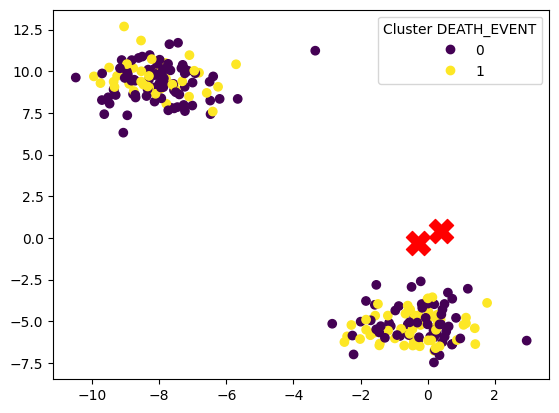

In [23]:
X_blobs, y_blobs = make_blobs(n_samples=len(X_train_scaled), centers=2, random_state=55)
scatter = plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=kmeans_scaled.labels_, cmap='viridis', marker='o') # create scatter plot
plt.scatter(kmeans_scaled.cluster_centers_[:, 0], kmeans_scaled.cluster_centers_[:, 1], s=300, c='red', marker='X')  # Cluster centers
plt.legend(*scatter.legend_elements(), title="Cluster DEATH_EVENT") # cluster color legend
plt.show()

**.................todo........................**

isolation forest?

naive-bayes?

**.............................................**

## Try PCA for 1 to n-1 components on: X_train, X_train_scaled X_train_resampled_scaled

In [61]:
# stages.keys() # ['DF', 'X_train', 'X_train_resampled', 'X_train_scaled', 'X_test_scaled', 'X_train_resampled_scaled', 'X_train_minmax', 'X_test_minmax', 'X_train_resampled_minmax']
algos = dict(
    decisiontree=(DecisionTreeClassifier, dict(random_state=55)),
    randomforest=(RandomForestClassifier, dict(random_state=55, n_estimators=19, bootstrap=True)),
    logisticregression=(linear_model.LogisticRegression, dict(random_state=55, max_iter=10000)),
    knn=(KNeighborsClassifier, dict(n_neighbors=3, weights='uniform')),
    kmeans=(KMeans, dict(random_state=55, n_clusters=2)),
)
pcas = dict()

def get_stage(stage_key): # DF|X|Y => '',  X_train => '_train',  X_train_resampled => '_train_resampled',  etc.
    if stage_key == 'DF' or stage_key == 'X' or stage_key == 'y': return ''
    return stage_key[1:]

def get_y_stage(stage_key): # DF|X|Y => '',  X_train => '_train',  X_train_resampled => '_train_resampled',  etc.
    stage_key = stage_key.replace('_scaled', '').replace('_minmax', '') # you don't scale y's
    if stage_key == 'DF' or stage_key == 'X' or stage_key == 'y': return ''
    return stage_key[1:]

for algo_key, algo in algos.items():
    for num_fts in range(1, len(X.columns)-1):
        for stage_key, stage in stages.items():
            if stage_key.startswith('y'): continue
            pca_key = f"{algo_key}{get_stage(stage_key)}_{num_fts}"
            pcas[pca_key] = dict(pca=PCA(n_components=num_fts),)
            pcas[pca_key]["stage"] = pcas[pca_key]["pca"].fit_transform(stage) # PCA sub-stage/dataframe
            test_stage_key = f"{stage_key.replace("_train", "_test").replace("_resampled", "")}"
            pcas[pca_key]["test_stage"] = pcas[pca_key]["pca"].transform(stages[test_stage_key]) # PCA sub-stage/dataframe   ——you don't resample testing (don't test synthetic)
            pcas[pca_key]["model"] = algo[0](**algo[1]) # instantiate model with args
            pcas[pca_key]["model"].fit(pcas[pca_key]["stage"], stages[f"y{get_y_stage(stage_key)}"]) # fit on
            pcas[pca_key]["predictions"] = pcas[pca_key]["model"].predict(pcas[pca_key]["test_stage"])
            pcas[pca_key]["accuracy_score"] = metrics.accuracy_score(stages[f"y{test_stage_key.replace("DF", "X").replace("_scaled", "").replace("_minmax", "")[1:]}"], pcas[pca_key]["predictions"])
print(pcas.keys())
pcas["decisiontree_8"]["pca"].components_ # explained_variance_
pcas["decisiontree_8"]["accuracy_score"]

dict_keys(['decisiontree_1', 'decisiontree_train_1', 'decisiontree_test_1', 'decisiontree_train_resampled_1', 'decisiontree_train_scaled_1', 'decisiontree_test_scaled_1', 'decisiontree_train_resampled_scaled_1', 'decisiontree_train_minmax_1', 'decisiontree_test_minmax_1', 'decisiontree_train_resampled_minmax_1', 'decisiontree_2', 'decisiontree_train_2', 'decisiontree_test_2', 'decisiontree_train_resampled_2', 'decisiontree_train_scaled_2', 'decisiontree_test_scaled_2', 'decisiontree_train_resampled_scaled_2', 'decisiontree_train_minmax_2', 'decisiontree_test_minmax_2', 'decisiontree_train_resampled_minmax_2', 'decisiontree_3', 'decisiontree_train_3', 'decisiontree_test_3', 'decisiontree_train_resampled_3', 'decisiontree_train_scaled_3', 'decisiontree_test_scaled_3', 'decisiontree_train_resampled_scaled_3', 'decisiontree_train_minmax_3', 'decisiontree_test_minmax_3', 'decisiontree_train_resampled_minmax_3', 'decisiontree_4', 'decisiontree_train_4', 'decisiontree_test_4', 'decisiontree_t

1.0